<a href="https://colab.research.google.com/github/imyoungchae/Ai/blob/main/VGGNET11_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [23]:
import os 
from skimage import io, transform
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt 
from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init
import torch.nn.functional as F
import torchvision.datasets  as ds
import torchvision.transforms  as tf
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,models

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from torchvision import transforms

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 레이블 처리

In [26]:
images_folder = '/content/drive/MyDrive/img3'
train_img =pd.read_csv('/content/drive/MyDrive/train_data1.csv')
test_img =pd.read_csv('/content/drive/MyDrive/test_data.csv')
#images_title = os.listdir(images_folder)
#images_title.sort()


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# N(비녹지): 0, S(반녹지): 1, G(녹지): 2
train_label = []
test_label = []

for i in train_img['0']:
    if 'non_green_space' in i:
        train_label.append(0)

    elif 'green_space_and_road' in i:
        train_label.append(1)

    elif 'green_space_and_etc' in i:
        train_label.append(1)

    elif 'green_space' in i:
        train_label.append(2)


for i in test_img['0']:
    if 'non_green_space' in i:
        test_label.append(0)

    elif 'green_space_and_road' in i:
        test_label.append(1)

    elif 'green_space_and_etc' in i:
        test_label.append(1)

    elif 'green_space' in i:
        test_label.append(2) 

In [29]:
train_data = pd.DataFrame(
    {'image': train_img['0'], 
    'label': train_label})

test_data = pd.DataFrame(
    {'image': test_img['0'], 
    'label': test_label})

In [30]:
train_data_sf = train_data.sample(frac = 1).reset_index(drop = True)
test_data_sf = test_data.sample(frac = 1).reset_index(drop = True)

# 데이터 분리 및 전처리

In [31]:
class ForestDataset(Dataset):

    def __init__(self, dataframe, root_dir, transform = None):

        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, 
                                self.dataframe.iloc[idx,0])
        image = io.imread(img_name)
        
        label = self.dataframe.iloc[idx,1]
        
        if self.transform:

            image = self.transform(image)


        sample = {'image': image, 'label': label}
        return image, label

In [32]:
train_data_sf = train_data_sf[:350]
test_data_sf = test_data_sf[:150]

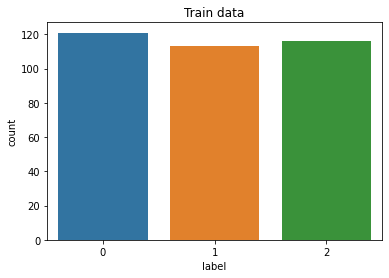

In [33]:
import seaborn as sns

sns.countplot(x = 'label', data = train_data_sf)
plt.title("Train data")
plt.show()


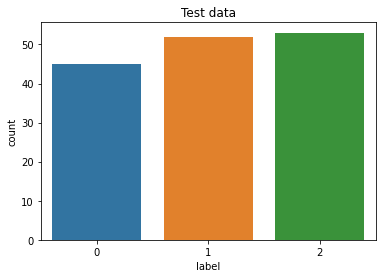

In [34]:
sns.countplot(x = 'label', data = test_data_sf)
plt.title("Test data")
plt.show()

In [35]:
print('train의 개수: {}'.format(len(train_data_sf)))
print('test의 개수: {}'.format(len(test_data_sf)))

train의 개수: 350
test의 개수: 150


In [36]:
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(128),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [37]:
train_dataset = ForestDataset(dataframe = train_data_sf, 
                              root_dir = images_folder, 
                              transform = data_transform)

test_dataset = ForestDataset(dataframe = test_data_sf, 
                             root_dir = images_folder, 
                             transform = data_transform)

train_loader = DataLoader(train_dataset, 
                          batch_size = 256, 
                          shuffle = True, 
                          num_workers = 0)

test_loader = DataLoader(test_dataset, 
                         batch_size = len(test_data), 
                         shuffle = True, 
                         num_workers = 0)

In [38]:
x, y = next(iter(test_loader))

# 학습

In [39]:
class VGG11(torch.nn.Module): 

    def __init__(self):
        super().__init__()


        # block 1
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool1 = nn.MaxPool2d((2,2), stride = (2,2))
        
        # block 2
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool2 = nn.MaxPool2d((2,2), stride = (2,2))

        # block 3
        self.layer3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.layer4 = nn.Sequential(nn.Conv2d(256, 256, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool3 = nn.MaxPool2d((2,2), stride = (2,2))

        # block 4
        self.layer5 = nn.Sequential(nn.Conv2d(256, 512, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.layer6 = nn.Sequential(nn.Conv2d(512, 512, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool4 = nn.MaxPool2d((2,2), stride = (2,2))

        # block 5
        self.layer7 = nn.Sequential(nn.Conv2d(512, 512, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.layer8 = nn.Sequential(nn.Conv2d(512, 512, kernel_size = (3,3), padding = 1), nn.ReLU())
        self.pool5 = nn.MaxPool2d((2,2), stride = (2,2))

        # FC Layers
        self.flat = nn.Flatten()

        self.fc1 = nn.Sequential(nn.Linear(512 * 4 * 4, 4096), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU())
        self.fc3 = nn.Linear(4096, 3)

        #self.act_funt = nn.Sigmoid()
        self.output = nn.Softmax(dim=1) 




    def forward(self, x):
        
        # block 1
        out = self.layer1(x)
        out = self.pool1(out)

        # block 2
        out = self.layer2(out)
        out = self.pool2(out)

        # block 3
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.pool3(out)

        # block 4
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.pool4(out)

        # block 5
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.pool5(out)

        # fc
        out = self.flat(out)

        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)

        #out = self.act_funt(out)
        prob = self.output(out)

        return prob


In [40]:
model1=VGG11()
model2=VGG11()
model3=VGG11()
model4=VGG11()

In [41]:
optimizer1=torch.optim.Adagrad(params=model1.parameters(),lr=0.1)
optimizer2=torch.optim.Adagrad(params=model2.parameters(),lr=0.01)
optimizer3=torch.optim.Adagrad(params=model3.parameters(),lr=0.001)
optimizer4=torch.optim.Adagrad(params=model4.parameters(),lr=0.0001)

In [42]:
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
criterion3 = nn.CrossEntropyLoss()
criterion4 = nn.CrossEntropyLoss()

In [43]:
num_epochs = 100
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()

In [44]:
train_loss_list1 = [] 
test_loss_list1 = []

train_loss_list2 = [] 
test_loss_list2 = []

train_loss_list3 = [] 
test_loss_list3 = []

train_loss_list4 = [] 
test_loss_list4 = []


model1.train()
model2.train()
model3.train()
model4.train()

checkpoint = 1
for epoch in range(num_epochs):
    for batch_idx, (x, y) in enumerate(train_loader):
       
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        optimizer4.zero_grad()

        train_pred1 = model1(x)
        train_pred2 = model2(x)
        train_pred3 = model3(x)
        train_pred4 = model4(x)

        loss1 = criterion1(train_pred1, y)
        loss2 = criterion2(train_pred2, y)
        loss3 = criterion3(train_pred3, y)
        loss4 = criterion4(train_pred4, y)

        train_loss1 = loss1.item()
        train_loss2 = loss2.item()
        train_loss3 = loss3.item()
        train_loss4 = loss4.item()

        loss1.backward()
        loss2.backward()
        loss3.backward()
        loss4.backward()

        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        optimizer4.step()

        if (epoch % 5 == 0) and (batch_idx == 1):
            model1.eval()
            model2.eval()
            model3.eval()
            model4.eval()

            test_loss1 = 0
            test_loss2 = 0
            test_loss3 = 0
            test_loss4 = 0
            with torch.no_grad():
                for data, target in test_loader:
                    test_pred1 = model1(data)
                    test_pred2 = model2(data)
                    test_pred3 = model3(data)
                    test_pred4 = model4(data)

                    test_loss1 += criterion1(test_pred1, target).item()
                    test_loss2 += criterion2(test_pred2, target).item()
                    test_loss3 += criterion3(test_pred3, target).item()
                    test_loss4 += criterion4(test_pred4, target).item()

            test_loss1 /= len(test_loader)
            test_loss2 /= len(test_loader)
            test_loss3 /= len(test_loader)
            test_loss4 /= len(test_loader)


            train_loss_list1.append(train_loss1)
            train_loss_list2.append(train_loss2)
            train_loss_list3.append(train_loss3)
            train_loss_list4.append(train_loss4)

            test_loss_list1.append(test_loss1)
            test_loss_list2.append(test_loss2)
            test_loss_list3.append(test_loss3)
            test_loss_list4.append(test_loss4)

            print('Epoch: {} | batch: {} '.format(epoch, batch_idx))
            print('--------------------------------------------------------------------------------------------------------\n')


Epoch: 0 | batch: 1 
--------------------------------------------------------------------------------------------------------

Epoch: 5 | batch: 1 
--------------------------------------------------------------------------------------------------------

Epoch: 10 | batch: 1 
--------------------------------------------------------------------------------------------------------

Epoch: 15 | batch: 1 
--------------------------------------------------------------------------------------------------------

Epoch: 20 | batch: 1 
--------------------------------------------------------------------------------------------------------

Epoch: 25 | batch: 1 
--------------------------------------------------------------------------------------------------------

Epoch: 30 | batch: 1 
--------------------------------------------------------------------------------------------------------

Epoch: 35 | batch: 1 
------------------------------------------------------------------------------------

In [45]:
#torch.save(model.state_dict(), 'vgg11_model_adagrad3')

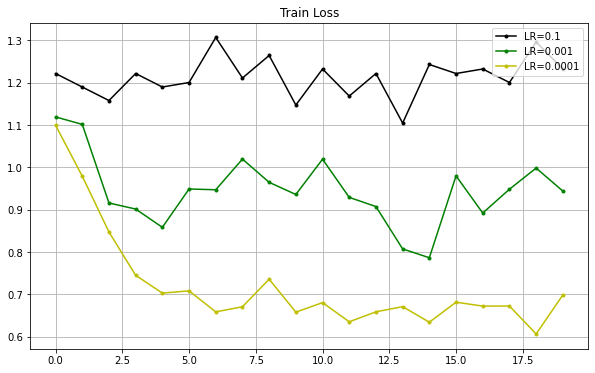

In [61]:
train1=train_loss_list1
train2=train_loss_list2
train3=train_loss_list3
train4=train_loss_list4


plt.figure(1, figsize = (10, 6))
plt.title('Train Loss')

plt.plot(train1, marker='.', c = 'black',label='LR=0.1')
#plt.plot(train2, marker='.', c = 'r',label='LR=0.01')
plt.plot(train3, marker='.', c = 'g',label='LR=0.001')
plt.plot(train4, marker='.', c = 'y',label='LR=0.0001')

plt.legend(loc='upper right')
plt.grid()
plt.ylim()
plt.show()

In [60]:
train1

[1.2216575145721436,
 1.1897426843643188,
 1.1578278541564941,
 1.221657633781433,
 1.1897426843643188,
 1.2003809213638306,
 1.306764006614685,
 1.2110192775726318,
 1.2642109394073486,
 1.1471894979476929,
 1.2322958707809448,
 1.1684660911560059,
 1.221657633781433,
 1.104636311531067,
 1.242934226989746,
 1.2216575145721436,
 1.2322958707809448,
 1.2003810405731201,
 1.2961257696151733,
 1.2322958707809448]

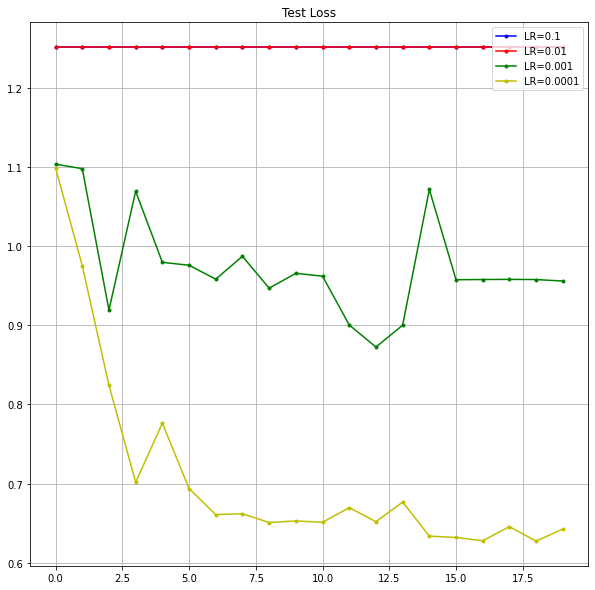

In [55]:
test1=test_loss_list1
test2=test_loss_list2
test3=test_loss_list3
test4=test_loss_list4

plt.figure(1, figsize = (10, 10))
plt.title('Test Loss')

plt.plot(test1, marker='.', c = 'b',label='LR=0.1')
plt.plot(test2, marker='.', c = 'r',label='LR=0.01')
plt.plot(test3, marker='.', c = 'g',label='LR=0.001')
plt.plot(test4, marker='.', c = 'y',label='LR=0.0001')

plt.legend(loc='upper right')
plt.grid()
plt.ylim()
plt.show()

# 성능평가

In [48]:
from sklearn.metrics import classification_report

In [49]:
model.eval()
test_labels = [] #np.array(None)
pred_labels = [] #np.array(None)

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim = 1)

        target = target.detach().numpy()
        pred = pred.detach().numpy()

        test_labels.append(target)
        pred_labels.append(pred)

NameError: ignored

In [ ]:
test_labels

In [ ]:
pred_labels

In [ ]:
pred_onehot = model(x)
pred = pred_onehot.argmax(dim = 1)
pred_onehot

In [ ]:
Y_test2 = y.detach().numpy()
pred2 = pred.detach().numpy()

In [ ]:
print(classification_report(y_true = y, y_pred = pred))

# 

In [ ]:
# 예측이 틀린 인덱스 번호 저장
incorrect_idx = []

# 모델이 예측한 값
model_predict = []

for idx in range(x.shape[0]):

    if (pred2[idx] != Y_test2[idx]):
        
        incorrect_idx.append(idx)
        model_predict.append(pred2[idx])


In [ ]:
toPILImage = ToPILImage()

In [ ]:
len(incorrect_idx)

In [ ]:
num = 0

f, axarr = plt.subplots(len(incorrect_idx),1,figsize = (300, 300))

for idx in incorrect_idx:
    axarr[num].imshow(toPILImage(x[idx]))

    axarr[num].title.set_text('predict: '+str(model_predict[num])+'\n'+'correct: '+str(y[idx]))

    num = num + 1

In [ ]:
torch.save(model.state_dict(), 'vgg11_model_adagrad.pt')